<a href="https://colab.research.google.com/github/febielin/febielin.github.io/blob/main/mutt_or_mop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mutt or Mop: Distinguishing Between Shaggy Komondors and Household Cleaning Tools Using Deep Learning**

CS131 - Computer Vision: Foundations and Applications \\
Final Project by Alexander Chon and Febie Lin



## ***NOTE: RUN STEPS 1 and 6-8 ONLY.***



### STEP 1: Import Statements

In [ ]:
import os
import datetime
import shutil
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### STEP 2: Resize mutt photos.

In [ ]:
unsized_mutts_path = "drive/MyDrive/Mutt_or_Mop/mutts"
resized_mutts_path = "drive/MyDrive/Mutt_or_Mop/mutt/mutts_resized"
new_size = (256, 256)

# resize every image
for img in os.listdir(unsized_mutts_path):
    image = Image.open(os.path.join(unsized_mutts_path, img))
    resized_image = image.resize(new_size, Image.ANTIALIAS)   # ANTIALIAS resampling filter: https://medium.com/illumination/resizing-images-in-python-using-python-imaging-library-without-losing-quality-2f0df1fbaebc
    resized_image.save(os.path.join(resized_mutts_path, img))

### STEP 3: Resize mop photos

In [ ]:
unsized_mops_path = "drive/MyDrive/Mutt_or_Mop/mops"
resized_mops_path = "drive/MyDrive/Mutt_or_Mop/mops/mops_resized"
new_size = (256, 256)

# resize every image
for img in os.listdir(unsized_mops_path):
    image = Image.open(os.path.join(unsized_mops_path, img))
    resized_image = image.resize(new_size, Image.ANTIALIAS)   # ANTIALIAS resampling filter: https://medium.com/illumination/resizing-images-in-python-using-python-imaging-library-without-losing-quality-2f0df1fbaebc
    resized_image.save(os.path.join(resized_mops_path, img))

### STEP 4: Split into train, validation, test

In [ ]:
def split_dataset(source_path, dest_path):
    # path to the new folders for the training, validation, and testing datasets
    train = os.path.join(dest_path, 'train')
    val = os.path.join(dest_path, 'validation')
    test = os.path.join(dest_path, 'test')

    all_images = [f for f in os.listdir(source_path)]
    np.random.shuffle(all_images)        # shuffle the mutts and mops

    # Generate the 40-30-30 split
    train_split_idx = int(len(all_images) * 0.4)     # marks the end of the training dataset
    val_split_idx = train_split_idx + int(len(all_images) * 0.3)     # marks the end of the validation dataset

    # move to their respective folders
    for i, img in enumerate(all_images):
        if i < train_split_idx:
            shutil.move(os.path.join(source_path, img), os.path.join(train, img))
        elif i < val_split_idx:
            shutil.move(os.path.join(source_path, img), os.path.join(val, img))
        else:
            shutil.move(os.path.join(source_path, img), os.path.join(test, img))

In [ ]:
source = 'drive/MyDrive/Mutt_or_Mop/imgs/mutt'
dest = 'drive/MyDrive/Mutt_or_Mop/mutt_datasets'
split_dataset(source, dest)

source = 'drive/MyDrive/Mutt_or_Mop/imgs/mop'
dest = 'drive/MyDrive/Mutt_or_Mop/mop_datasets'
split_dataset(source, dest)

### STEP 5: Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,            # normalize pizels to [0, 1]
    rotation_range=180,        # randomly rotate up to 180 degrees
    width_shift_range=0.3,     # randomly shift width up to 30%
    height_shift_range=0.3,    # randomly shift height up to 30%
    shear_range=0.3,           # random shearing up to 30%
    zoom_range=0.3,            # randomly zooms in/out, up to 30%
    horizontal_flip=True,      # randomly flips image horizontally
    fill_mode='nearest')       # fill in new pixels with those nearest by


original = 'drive/MyDrive/Mutt_or_Mop/datasets/train'
augmented = 'drive/MyDrive/Mutt_or_Mop/augment'

generator = datagen.flow_from_directory(
    original,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    save_to_dir=augmented,
    save_prefix='augmented_',
    save_format='jpg')

for i in range(6):     # brings our split up to 66-17-17
    batch = generator.next()

Found 90 images belonging to 2 classes.


### STEP 6: Model Training


In [ ]:
train = ImageDataGenerator(rescale=1./255)            # normalize pizels to [0, 1]
validation = ImageDataGenerator(rescale=1./255)

train_generator = train.flow_from_directory(
    'drive/MyDrive/Mutt_or_Mop/datasets/train',
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary')

validation_generator = validation.flow_from_directory(
    'drive/MyDrive/Mutt_or_Mop/datasets/validation',
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary')


Found 267 images belonging to 2 classes.
Found 67 images belonging to 2 classes.


In [ ]:
# MODEL ARCHITECTURE
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),     # add dropout layers to address overfitting

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# keep track of our best model via validation loss
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [ ]:
# train
history = model.fit(
    train_generator,
    steps_per_epoch=17,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=5,
    callbacks=[checkpoint_callback])

Epoch 1/8
17/17 [==============================] - ETA: 0s - loss: 4.9736 - accuracy: 0.5468
Epoch 1: val_loss improved from inf to 0.64812, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 99s 6s/step - loss: 4.9736 - accuracy: 0.5468 - val_loss: 0.6481 - val_accuracy: 0.5970
Epoch 2/8
17/17 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.6704
Epoch 2: val_loss improved from 0.64812 to 0.51349, saving model to best_model.h5
17/17 [==============================] - 8s 415ms/step - loss: 0.5647 - accuracy: 0.6704 - val_loss: 0.5135 - val_accuracy: 0.7612
Epoch 3/8
17/17 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8652
Epoch 3: val_loss improved from 0.51349 to 0.28359, saving model to best_model.h5
17/17 [==============================] - 4s 263ms/step - loss: 0.3630 - accuracy: 0.8652 - val_loss: 0.2836 - val_accuracy: 0.8955
Epoch 4/8
17/17 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.8989
Epoch 4: val_loss improved from 0.28359 to 0.27472, saving model to best_model.h5
17/17 [==============================] - 11s 686ms/step - loss: 0.2750 - accuracy: 0

### STEP 7: Model Testing

In [ ]:
loaded_model = load_model('best_model.h5')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'drive/MyDrive/Mutt_or_Mop/datasets/test',
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary')

test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print("Test Loss: {0}".format(test_loss))
print("Test Accuracy: {0}".format(test_accuracy))


# ---- OBTAIN THE CSV FILE WITH TRUE VS PREDICTED ----

predictions = loaded_model.predict(test_generator)
predicted_classes = np.round(predictions).flatten()     # goes to 0 or 1
true_classes = test_generator.classes
filenames = test_generator.filenames

results_df = pd.DataFrame({
    'filename': filenames,
    'true': true_classes,
    'predicted': predicted_classes,
    'probability': predictions.flatten()
})

results_df.to_csv('results.csv', index=False)

Found 68 images belonging to 2 classes.
5/5 [==============================] - 0s 63ms/step
Test Loss:  0.2571265697479248
Test Accuracy:  0.8823529481887817


### STEP 8: Visualization

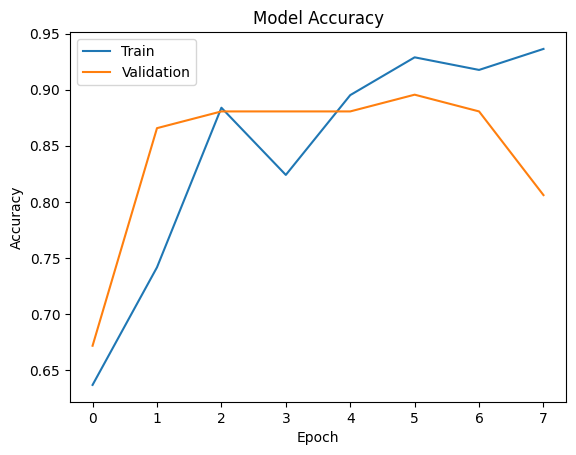

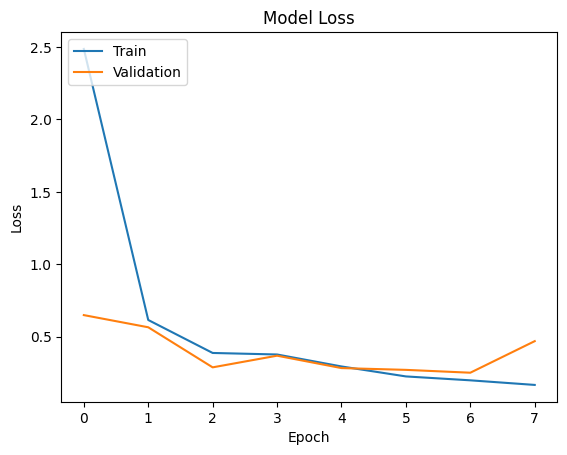

In [ ]:
# Accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()